<a href="https://colab.research.google.com/github/sabbirarif/Thesis_Project/blob/main/Brinjal_Disease_Detection_Using_Deep_Learning_main_file_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Dependencies

In [ ]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=25

## Importing Dataset

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Augmented Data",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1187 files belonging to 4 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Brinjal Fruit Cracking',
 'Brinjal fruit and shoot borer',
 'Healthy Brinjal',
 'Phomopsis blight']

In [ ]:
d1=tf.keras.preprocessing.image_dataset_from_directory(
    "Brinjal Fruit Cracking",
    batch_size = 1
)
d2=tf.keras.preprocessing.image_dataset_from_directory(
    "Brinjal fruit and shoot borer",
    batch_size = 1
)
d3=tf.keras.preprocessing.image_dataset_from_directory(
    "Healthy Brinjal",
    batch_size = 1
)
d4=tf.keras.preprocessing.image_dataset_from_directory(
    "Phomopsis blight",
    batch_size = 1
)

Found 112 files belonging to 1 classes.
Found 531 files belonging to 1 classes.
Found 273 files belonging to 1 classes.
Found 271 files belonging to 1 classes.


In [ ]:
len(d1)

112

([<matplotlib.patches.Wedge at 0x234a83f4ac0>,
 [Text(-0.32131497664204167, 1.052025040474572, 'Brinjal Fruit Cracking'),
  Text(-1.0010345384432071, -0.4559932596473282, 'Brinjal fruit and shoot borer'),
  Text(0.9163314365148466, -0.608552954519685, 'Healthy Brinjal'),
  Text(0.7230434003407038, 0.8289802417571561, 'Phomopsis blight')],
 [Text(-0.17526271453202272, 0.5738318402588573, '9%'),
  Text(-0.5460188391508402, -0.24872359617126988, '45%'),
  Text(0.49981714718991627, -0.3319379751925554, '23%'),
  Text(0.39438730927674753, 0.45217104095844873, '23%')])

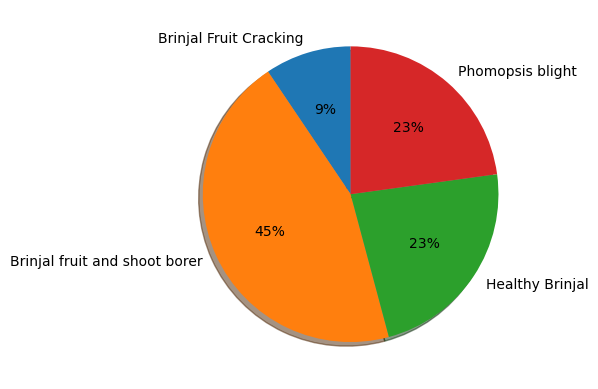

In [ ]:
name = class_names
data = [len(d1), len(d2), len(d3), len(d4)]
plt.pie(data, labels=name, autopct='%0.f%%', shadow=True, startangle=90)

In [ ]:
len(dataset)

38

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 3 1 1 1 1 2 3 1 2 1 2 0 1 2 2 1 1 1 1 2 1 3 1 2 3 0 1 3 2 1]


## Visualizing Dataset

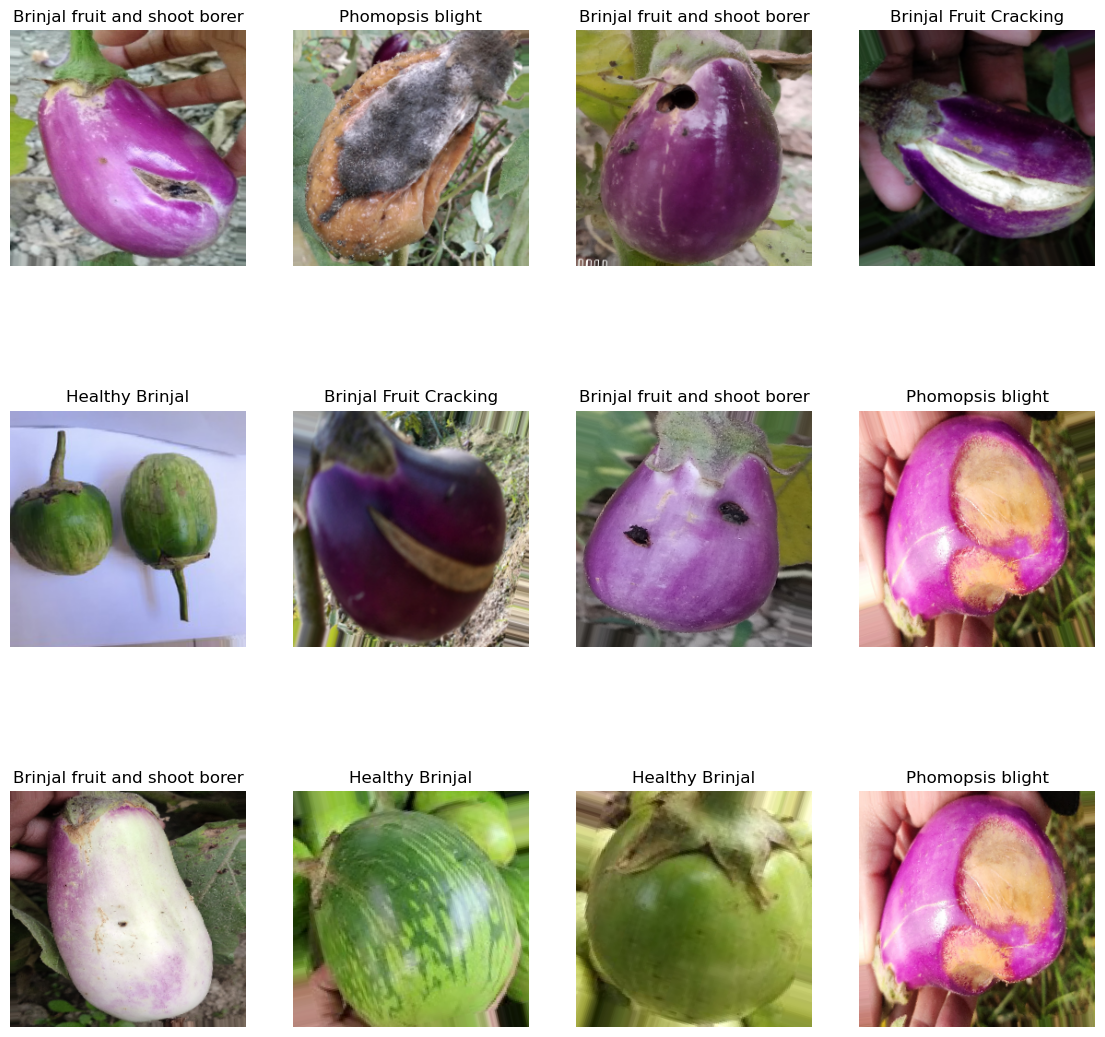

In [ ]:
plt.figure(figsize=(14, 14))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Train Test Split

In [ ]:
train_size = 0.7
len(dataset)*train_size

26.599999999999998

In [ ]:
train_ds = dataset.take(26)
len(train_ds)

26

In [ ]:
test_ds = dataset.skip(26)
len(test_ds)

12

In [ ]:
val_size=0.15
len(dataset)*val_size

5.7

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

6

In [ ]:
#train data 70%, Test data 15%, Validation 15%
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

26

In [ ]:
len(val_ds)

5

In [ ]:
len(test_ds)

7

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## General Preprocess and Augmentation

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building The Model

## CNN Model

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model_01 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_01.build(input_shape=input_shape)

In [ ]:
model_01.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_118 (Conv2D)         (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_119 (Conv2D)         (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_120 (Conv2D)         (32, 60, 60, 128)        

In [ ]:
model_01.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history_01 = model_01.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/25
26/26 [==============================] - 22s 810ms/step - loss: 1.5074 - accuracy: 0.4471 - val_loss: 1.2705 - val_accuracy: 0.6250
Epoch 2/25
26/26 [==============================] - 21s 821ms/step - loss: 0.8913 - accuracy: 0.7024 - val_loss: 0.6858 - val_accuracy: 0.7688
Epoch 3/25
26/26 [==============================] - 21s 804ms/step - loss: 0.7171 - accuracy: 0.7733 - val_loss: 0.6095 - val_accuracy: 0.7937
Epoch 4/25
26/26 [==============================] - 22s 830ms/step - loss: 0.6598 - accuracy: 0.7920 - val_loss: 0.6285 - val_accuracy: 0.7875
Epoch 5/25
26/26 [==============================] - 23s 866ms/step - loss: 0.5493 - accuracy: 0.8107 - val_loss: 0.4601 - val_accuracy: 0.8313
Epoch 6/25
26/26 [==============================] - 22s 860ms/step - loss: 0.4981 - accuracy: 0.8344 - val_loss: 0.4842 - val_accuracy: 0.8125
Epoch 7/25
26/26 [==============================] - 23s 865ms/step - loss: 0.4831 - accuracy: 0.8319 - val_loss: 0.4744 - val_accuracy: 0.8313

In [ ]:
scores_01 = model_01.evaluate(test_ds)

7/7 [==============================] - 1s 193ms/step - loss: 0.0949 - accuracy: 0.9777


## Plotting the Accuracy of CNN

In [ ]:
acc_01 = history_01.history['accuracy']
val_acc_01 = history_01.history['val_accuracy']

loss_01 = history_01.history['loss']
val_loss_01 = history_01.history['val_loss']

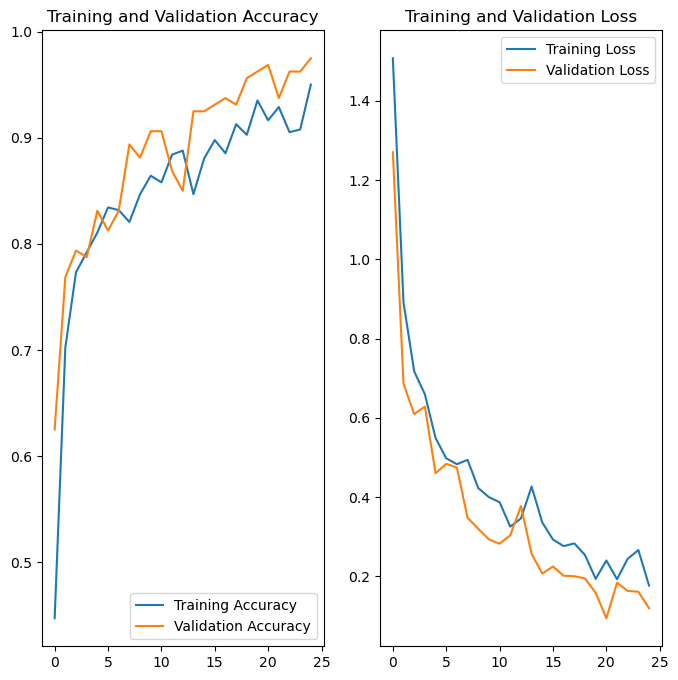

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_01, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_01, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_01, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_01, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
cnn_acc_01=scores_01[1]*100
print(f"Test Accuracy: ",cnn_acc_01)

Test Accuracy:  97.76785969734192


## Resnet50 Model

In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
model_04 = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,input_shape=(256,256,3),
                                                          pooling='avg',classes=4,
                                                          weights='imagenet')
for each_layer in pretrained_model.layers:
    each_layer.trainable=True

model_04.add(pretrained_model)


In [ ]:
model_04.add(Flatten())
model_04.add(Dense(512, activation='relu'))
model_04.add(Dense(4, activation='softmax'))

In [ ]:
model_04.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 24,585,732
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model_04.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_04 = model_04.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
26/26 [==============================] - 121s 4s/step - loss: 0.8924 - accuracy: 0.7671 - val_loss: 56308.2070 - val_accuracy: 0.4313
Epoch 2/20
26/26 [==============================] - 125s 5s/step - loss: 0.6548 - accuracy: 0.8144 - val_loss: 9770.2637 - val_accuracy: 0.1937
Epoch 3/20
26/26 [==============================] - 131s 5s/step - loss: 0.4123 - accuracy: 0.8730 - val_loss: 175.4603 - val_accuracy: 0.1937
Epoch 4/20
26/26 [==============================] - 126s 5s/step - loss: 0.2721 - accuracy: 0.9153 - val_loss: 166.4924 - val_accuracy: 0.4375
Epoch 5/20
26/26 [==============================] - 123s 5s/step - loss: 0.2474 - accuracy: 0.9153 - val_loss: 23.2626 - val_accuracy: 0.5125
Epoch 6/20
26/26 [==============================] - 124s 5s/step - loss: 0.1609 - accuracy: 0.9452 - val_loss: 1.1619 - val_accuracy: 0.8188
Epoch 7/20
26/26 [==============================] - 125s 5s/step - loss: 0.1513 - accuracy: 0.9502 - val_loss: 19.8638 - val_accuracy: 0.3125


In [ ]:
scores_04 = model_04.evaluate(test_ds)

7/7 [==============================] - 9s 1s/step - loss: 0.1329 - accuracy: 0.9464


## Plotting the Accuracy of ResNet-50

In [ ]:
acc_04 = history_04.history['accuracy']
val_acc_04= history_04.history['val_accuracy']

loss_04 = history_04.history['loss']
val_loss_04 = history_04.history['val_loss']


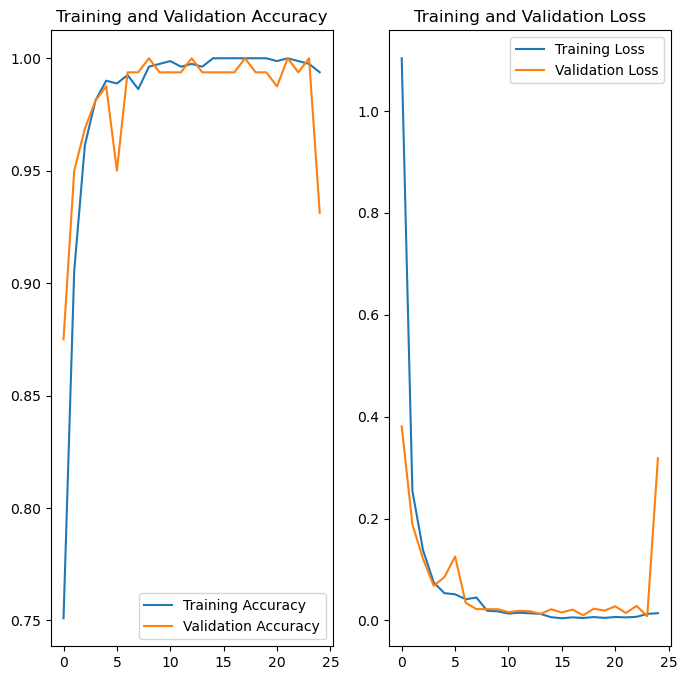

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_04, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_04, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_04, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_04, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
res_acc_04=scores_04[1]*100
print(f"Test Accuracy: ",res_acc_04)

Test Accuracy:  94.64285969734192
